In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Support Vector Machines

(com material adaptado do livro texto)

## Classificação

In [2]:
def plot_predictions(clf, axes):
    # Constroi uma lista de valores das variáveis independentes
    # que cubra o espaço amostral.
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    
    # Constroi as predições (binárias) e a função de decisão (contínua).
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)

    # Desenha a curva de decisão e as curvas de nível da função de decisão.
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "bs")
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

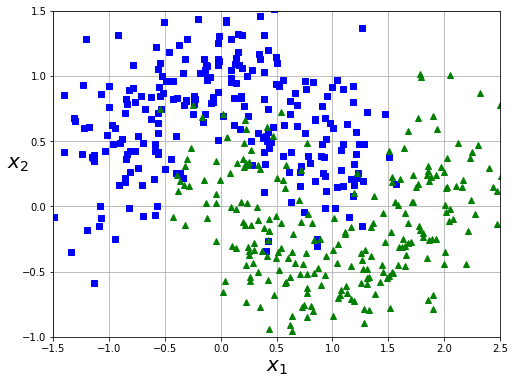

In [3]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.3, random_state=RANDOM_SEED)

plt.figure(figsize=(8,6))
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

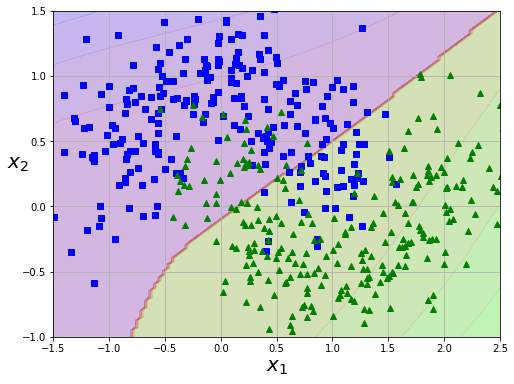

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import LinearSVC, SVC

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=1e-5, dual=False, random_state=RANDOM_SEED))
    ])

polynomial_svm_clf.fit(X, y)

plt.figure(figsize=(8,6))
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

{'svm_clf__C': 10.0}


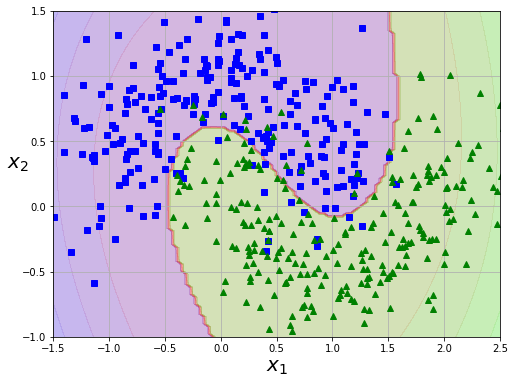

In [5]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from pprint import pprint

grid = GridSearchCV(
    polynomial_svm_clf, 
    {
        'svm_clf__C': [10**k for k in np.arange(-3, 5, 0.5)]
    },
    scoring='accuracy',
    cv=ShuffleSplit(n_splits=100, test_size=0.25, random_state=RANDOM_SEED),
    n_jobs=-1
)
grid.fit(X, y)

print(grid.best_params_)

plt.figure(figsize=(8,6))
plot_predictions(grid, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

**Atividade:** 
- Como funciona e para que serve o ShuffleSplit que eu usei no GridSearchCV?

**R:** 
- o argumento cv: "Determines the cross-validation splitting strategy".

O ShuffleSplit "embaralha" os dados e os separa n vezes, e separa os dados em amostras de treinamento e teste, nos indicando os índices de cada um; Nesse caso, foi utilizado para fazer um cross-validation de vários hiperparâmetros (lista na chave svm_clf__C), de modo a obter o hiperparâmetro ótimo.

Vamos analisar a acurácia real do classificador usando validação cruzada, e alterando o parâmetro de regularização $C$:

C = 0.00100: mean_accuracy = 0.836, stddev_accuracy = 0.031
C = 0.00316: mean_accuracy = 0.847, stddev_accuracy = 0.032
C = 0.01000: mean_accuracy = 0.858, stddev_accuracy = 0.031
C = 0.03162: mean_accuracy = 0.870, stddev_accuracy = 0.028
C = 0.10000: mean_accuracy = 0.885, stddev_accuracy = 0.028
C = 0.31623: mean_accuracy = 0.907, stddev_accuracy = 0.025
C = 1.00000: mean_accuracy = 0.924, stddev_accuracy = 0.024
C = 3.16228: mean_accuracy = 0.931, stddev_accuracy = 0.021
C = 10.00000: mean_accuracy = 0.931, stddev_accuracy = 0.019
C = 31.62278: mean_accuracy = 0.930, stddev_accuracy = 0.019
C = 100.00000: mean_accuracy = 0.929, stddev_accuracy = 0.020
C = 316.22777: mean_accuracy = 0.928, stddev_accuracy = 0.020
C = 1000.00000: mean_accuracy = 0.928, stddev_accuracy = 0.020
C = 3162.27766: mean_accuracy = 0.928, stddev_accuracy = 0.020
C = 10000.00000: mean_accuracy = 0.928, stddev_accuracy = 0.020
C = 31622.77660: mean_accuracy = 0.928, stddev_accuracy = 0.020


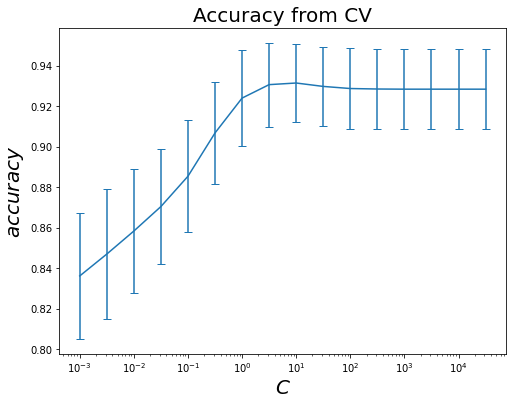

In [6]:
P = np.array([p['svm_clf__C'] for p in grid.cv_results_['params']])
M = grid.cv_results_['mean_test_score']
S = grid.cv_results_['std_test_score']

for p, m, s in zip(P, M, S):
    print('C = {:.5f}: mean_accuracy = {:.3f}, stddev_accuracy = {:.3f}'.format(p, m, s))

plt.figure(figsize=(8,6))
plt.errorbar(P, M, S, capsize=4)
plt.semilogx()
plt.title('Accuracy from CV', fontsize=20)
plt.xlabel(r"$C$", fontsize=20)
plt.ylabel(r"$accuracy$", fontsize=20)
plt.show()

**Atividade:** 
- Explique o gráfico acima em termos do tradeoff bias/variance.

**R:** No começo do gráfico é possível observar um caso de underfitting. Nesse caso, temos bias e variance elevados.

Para valores de $C > 10^1$, é possível observar um caso de oerfitting, onde temos uma variance um pouco menor que no caso de underfitting.

No entanto, pode-se observar que há um ponto de ótimo para o hiperparâmetro.

**Atividade:** Teste o desempenho dos classificadores abaixo no dataset anterior (moons)

- LinearSVC
- SVC, com kernel:
    - polinomial
    - RBF
   
Apresente os seguintes resultados:

- parâmetros ótimos
- Acurácia

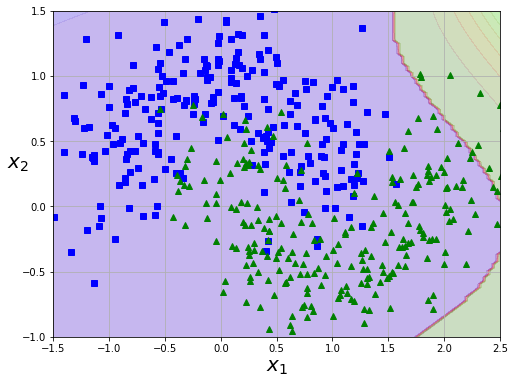

{'kernel_pol_svm_clf__C': 1000.0}


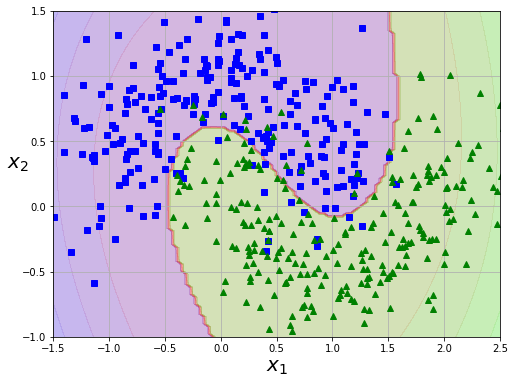

C = 0.00100: mean_accuracy = 0.501, stddev_accuracy = 0.051
C = 0.00316: mean_accuracy = 0.555, stddev_accuracy = 0.074
C = 0.01000: mean_accuracy = 0.638, stddev_accuracy = 0.085
C = 0.03162: mean_accuracy = 0.720, stddev_accuracy = 0.062
C = 0.10000: mean_accuracy = 0.779, stddev_accuracy = 0.058
C = 0.31623: mean_accuracy = 0.822, stddev_accuracy = 0.051
C = 1.00000: mean_accuracy = 0.878, stddev_accuracy = 0.032
C = 3.16228: mean_accuracy = 0.902, stddev_accuracy = 0.028
C = 10.00000: mean_accuracy = 0.912, stddev_accuracy = 0.024
C = 31.62278: mean_accuracy = 0.916, stddev_accuracy = 0.024
C = 100.00000: mean_accuracy = 0.919, stddev_accuracy = 0.021
C = 316.22777: mean_accuracy = 0.920, stddev_accuracy = 0.022
C = 1000.00000: mean_accuracy = 0.920, stddev_accuracy = 0.023
C = 3162.27766: mean_accuracy = 0.917, stddev_accuracy = 0.023
C = 10000.00000: mean_accuracy = 0.914, stddev_accuracy = 0.021
C = 31622.77660: mean_accuracy = 0.910, stddev_accuracy = 0.023


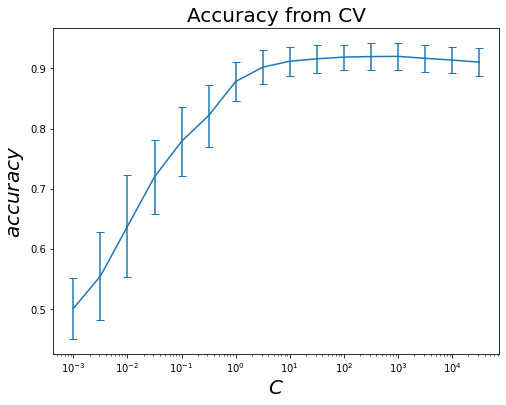

In [7]:
from sklearn.svm import SVC

# SVC, com kernel polinomial

kernel_poly_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("kernel_pol_svm_clf", SVC(C=1e-5, kernel='poly', random_state=RANDOM_SEED))
    ])

kernel_poly_svm_clf.fit(X, y)

plt.figure(figsize=(8,6))
plot_predictions(kernel_poly_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

grid_kernel_poly = GridSearchCV(
    kernel_poly_svm_clf, 
    {
        'kernel_pol_svm_clf__C': [10**k for k in np.arange(-3, 5, 0.5)]
    },
    scoring='accuracy',
    cv=ShuffleSplit(n_splits=100, test_size=0.25, random_state=RANDOM_SEED),
    n_jobs=-1
)
grid_kernel_poly.fit(X, y)

print(grid_kernel_poly.best_params_)

plt.figure(figsize=(8,6))
plot_predictions(grid, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

P = np.array([p['kernel_pol_svm_clf__C'] for p in grid_kernel_poly.cv_results_['params']])
M = grid_kernel_poly.cv_results_['mean_test_score']
S = grid_kernel_poly.cv_results_['std_test_score']

for p, m, s in zip(P, M, S):
    print('C = {:.5f}: mean_accuracy = {:.3f}, stddev_accuracy = {:.3f}'.format(p, m, s))

plt.figure(figsize=(8,6))
plt.errorbar(P, M, S, capsize=4)
plt.semilogx()
plt.title('Accuracy from CV', fontsize=20)
plt.xlabel(r"$C$", fontsize=20)
plt.ylabel(r"$accuracy$", fontsize=20)
plt.show()

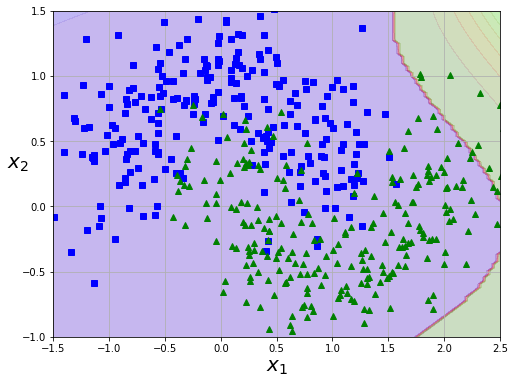

{'kernel_rbf_svm_clf__C': 100.0}


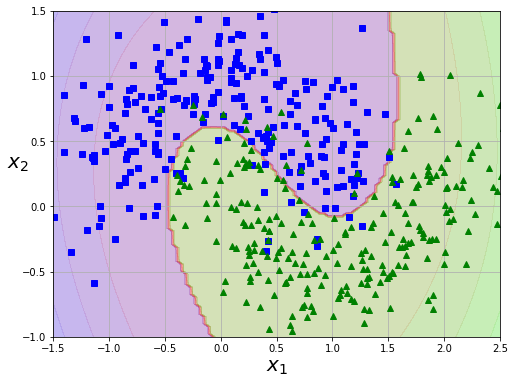

C = 0.00100: mean_accuracy = 0.468, stddev_accuracy = 0.023
C = 0.00316: mean_accuracy = 0.468, stddev_accuracy = 0.023
C = 0.01000: mean_accuracy = 0.507, stddev_accuracy = 0.059
C = 0.03162: mean_accuracy = 0.856, stddev_accuracy = 0.030
C = 0.10000: mean_accuracy = 0.869, stddev_accuracy = 0.026
C = 0.31623: mean_accuracy = 0.887, stddev_accuracy = 0.026
C = 1.00000: mean_accuracy = 0.902, stddev_accuracy = 0.026
C = 3.16228: mean_accuracy = 0.912, stddev_accuracy = 0.023
C = 10.00000: mean_accuracy = 0.918, stddev_accuracy = 0.021
C = 31.62278: mean_accuracy = 0.921, stddev_accuracy = 0.019
C = 100.00000: mean_accuracy = 0.924, stddev_accuracy = 0.020
C = 316.22777: mean_accuracy = 0.923, stddev_accuracy = 0.020
C = 1000.00000: mean_accuracy = 0.920, stddev_accuracy = 0.021
C = 3162.27766: mean_accuracy = 0.916, stddev_accuracy = 0.022
C = 10000.00000: mean_accuracy = 0.910, stddev_accuracy = 0.024
C = 31622.77660: mean_accuracy = 0.903, stddev_accuracy = 0.025


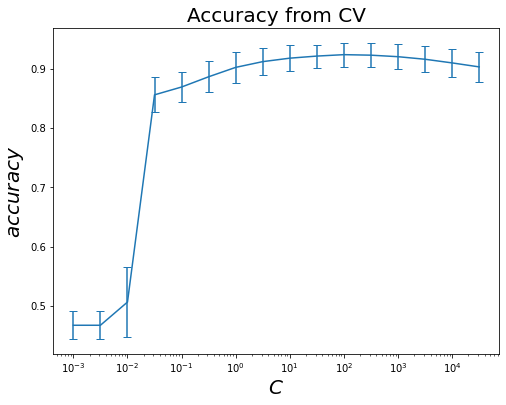

In [8]:
# SVC, com kernel rbf

kernel_rbf_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("kernel_rbf_svm_clf", SVC(C=1e-5, kernel='rbf', random_state=RANDOM_SEED))
    ])

kernel_rbf_svm_clf.fit(X, y)

plt.figure(figsize=(8,6))
plot_predictions(kernel_poly_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

grid_kernel_rbf = GridSearchCV(
    kernel_rbf_svm_clf, 
    {
        'kernel_rbf_svm_clf__C': [10**k for k in np.arange(-3, 5, 0.5)]
    },
    scoring='accuracy',
    cv=ShuffleSplit(n_splits=100, test_size=0.25, random_state=RANDOM_SEED),
    n_jobs=-1
)
grid_kernel_rbf.fit(X, y)

print(grid_kernel_rbf.best_params_)

plt.figure(figsize=(8,6))
plot_predictions(grid, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

P = np.array([p['kernel_rbf_svm_clf__C'] for p in grid_kernel_rbf.cv_results_['params']])
M = grid_kernel_rbf.cv_results_['mean_test_score']
S = grid_kernel_rbf.cv_results_['std_test_score']

for p, m, s in zip(P, M, S):
    print('C = {:.5f}: mean_accuracy = {:.3f}, stddev_accuracy = {:.3f}'.format(p, m, s))

plt.figure(figsize=(8,6))
plt.errorbar(P, M, S, capsize=4)
plt.semilogx()
plt.title('Accuracy from CV', fontsize=20)
plt.xlabel(r"$C$", fontsize=20)
plt.ylabel(r"$accuracy$", fontsize=20)
plt.show()

**R:**


## Regressão

Podemos usar support vector machines para regressão também.

- Em problemas de classificação com SVM queremos construir uma fronteira de decisão tal que a "avenida de separação" entre classes é a maior possível. Dentro desta "avenida" queremos o menor número de pontos possível.

- A idéia de usar SVM para regressão é o contrário: queremos construir um ajuste de função tal que a "avenida" contenha o **maior** número de pontos possível, para uma dada largura!

Vamos ilustrar estes pontos com um exemplo:

In [7]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [8]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma='scale')
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

In [9]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma='scale')
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma='scale')
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

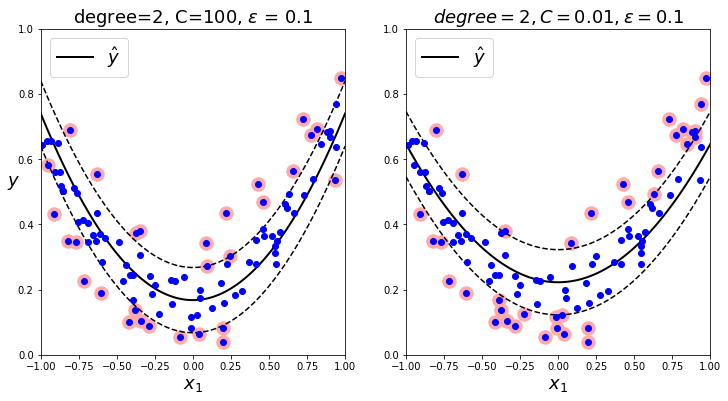

In [10]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"degree={}, C={}, $\epsilon$ = {}".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)

plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

**Atividade:** Explique o efeito do parâmetro de regularização C

**R:**

Vamos praticar usando o dataset "California Housing" do scikit-learn

In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [ ]:
print(housing['DESCR'])

In [ ]:
from pprint import pprint
pprint(housing)

In [ ]:
print(housing['DESCR'])

In [ ]:
X = pd.DataFrame(housing['data'], columns=housing['feature_names'])
y = pd.Series(housing['target'], name='MedHouseValue')

In [ ]:
y.describe()

In [ ]:
y[y >= 5.0]

In [ ]:
X.info()

In [ ]:
X.hist(figsize=(15,15), bins=100)
plt.show()

In [ ]:
X.describe()

Tem uns outliers malucos aparentemente! Onde já se viu um distrito onde a ocupação média dos imóveis é mais de 1000 pessoas!

In [ ]:
X[X.AveOccup > 100]

**Atividade:** Descubra o que aconteceu.

**R:**

 Parece que essas "casas" tem ocupação alta mesmo, ainda mais nos Estados Unidos (e no Brasil). 
 
Temos um problema também em relação ao número de cômodos:

In [ ]:
X[X.AveRooms > 50]

**Atividade:** Explique esse fenômeno também

**R:**

Para não misturar tipos de "residências", vamos filtrar o dataset e eliminar alguns outliers. Vamos nos restringir a um número de cômodos menor que 15, e uma ocupação média menor que 10. 

Vamos também eliminar os distritos onde o valor mediano dos imóveis excede $5.0$.

In [ ]:
valid = (X.AveRooms[:] < 15) & (X.AveOccup < 10) & (y < 5.0)
X_filt = X[valid]
y_filt = y[valid]

In [ ]:
X_filt.info()

In [ ]:
X_filt.hist(figsize=(12, 12), bins=100)
plt.show()

In [ ]:
y_filt.hist(bins=100)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_filt, y_filt, test_size=0.33)

Support Vector Machines são bastante eficientes para conjuntos de dados pequenos, mas seu processo de treinamento é extremamente lento. Para escolher o valor ótimo do parâmetro de regularização $C$ vamos reamostrar os dados e fazer a busca por validação cruzada em um dataset pequeno.

In [ ]:
from sklearn.utils import resample

X_train_small, y_train_small = resample(X_train, y_train, replace=False, n_samples=500)

In [ ]:
%%time
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('reg', SVR(C=1, epsilon=0.1))
    ]),
    {
        'reg__C': [10**k for k in range(-4, 7)]
    },
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1
)

grid.fit(X_train_small, y_train_small)
print(grid.best_params_)

In [ ]:
P = [p['reg__C'] for p in grid.cv_results_['params']]
M = -grid.cv_results_['mean_test_score']
S = np.log(grid.cv_results_['std_test_score'] + 1)

for p, m, s in zip(P, M, S):
    print(p, m, s)
    
plt.figure(figsize=(8,6))
plt.errorbar(P, M, S, capsize=4)
plt.semilogx()
plt.title('MSE from CV', fontsize=20)
plt.xlabel(r"$C$", fontsize=20)
plt.ylabel(r"$y$", fontsize=20, rotation=0)
plt.show()


**Atividade:** Mais uma vez, explique esse gráfico em termos do tradeoff bias/variance

**R:**

Vamos tentar também ajustar o parâmetro $\gamma$ do modelo (ver 'Gaussian RBF Kernel' no livro texto):

In [ ]:
%%time
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('reg', SVR(C=1, epsilon=0.1, gamma=0.1))
    ]),
    {
        'reg__gamma': [10**k for k in range(-7, 5)]
    },
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1
)

grid.fit(X_train_small, y_train_small)
print(grid.best_params_)

In [ ]:
P = [p['reg__gamma'] for p in grid.cv_results_['params']]
M = -grid.cv_results_['mean_test_score']
S = np.log(grid.cv_results_['std_test_score'] + 1)

for p, m, s in zip(P, M, S):
    print(p, m, s)
    
plt.figure(figsize=(8,6))
plt.errorbar(P, M, S, capsize=4)
plt.semilogx()
plt.title('MSE from CV', fontsize=20)
plt.xlabel(r"$\gamma$", fontsize=20)
plt.ylabel(r"$y$", fontsize=20, rotation=0)
plt.show()


**Atividade:** yadda yadda yadda tradeoff bias/variance you know what to do :)

**R:**

Finalmente, vamos testar o desempenho final do modelo:

In [ ]:
%%time
model = grid.best_estimator_
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test, y_pred)))

Vamos comparar com um regressor linear:

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
%%time
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

In [ ]:
y_pred_lin = lin_reg.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred_lin)))

Parece que o regressor SVM é mais preciso, mas requer um tempo de treinamento várias ordens de magnitude maior que o regressor linear. 

**Atividade:** A unidade de medida da variável dependente é "dezenas de milhares de dólares". Explique para seu chefe porque você merece uma promoção pelo seu trabalho com um regressor SVM enquanto seu colega (que não fez a disciplina de Machine Learning) usou uma regressão linear simples.

**R:**

**Atividades:**

- Qual a idéia fundamental das Support Vector Machines? O que são vetores de suporte?

- (Desafio) A segunda idéia mais importante das SVMs é o uso de kernels. Os kernels permitiram a expansão das SVMs para além dos modelos lineares. Em particular, o kernel RBF (radial-basis function) é bastante popular entre os usuários de SVMs, e apresenta desempenho bem elevado em geral. O que são kernels? Qual a sua relação com o problema de otimização dual das SVMs?

- Se dobrarmos o número de features em uma modelagem SVM, quanto sobe o tempo de treinamento de um classificador SVM linear? E de um SVM RBF?

- Se dobrarmos o número de amostras de treinamento de um classificador SVM linear, quanto sobe o tempo de treinamento? E se for um classificador SVM RBF?